<center><h1> Tropical cyclone BUFR decoding </h1></center>

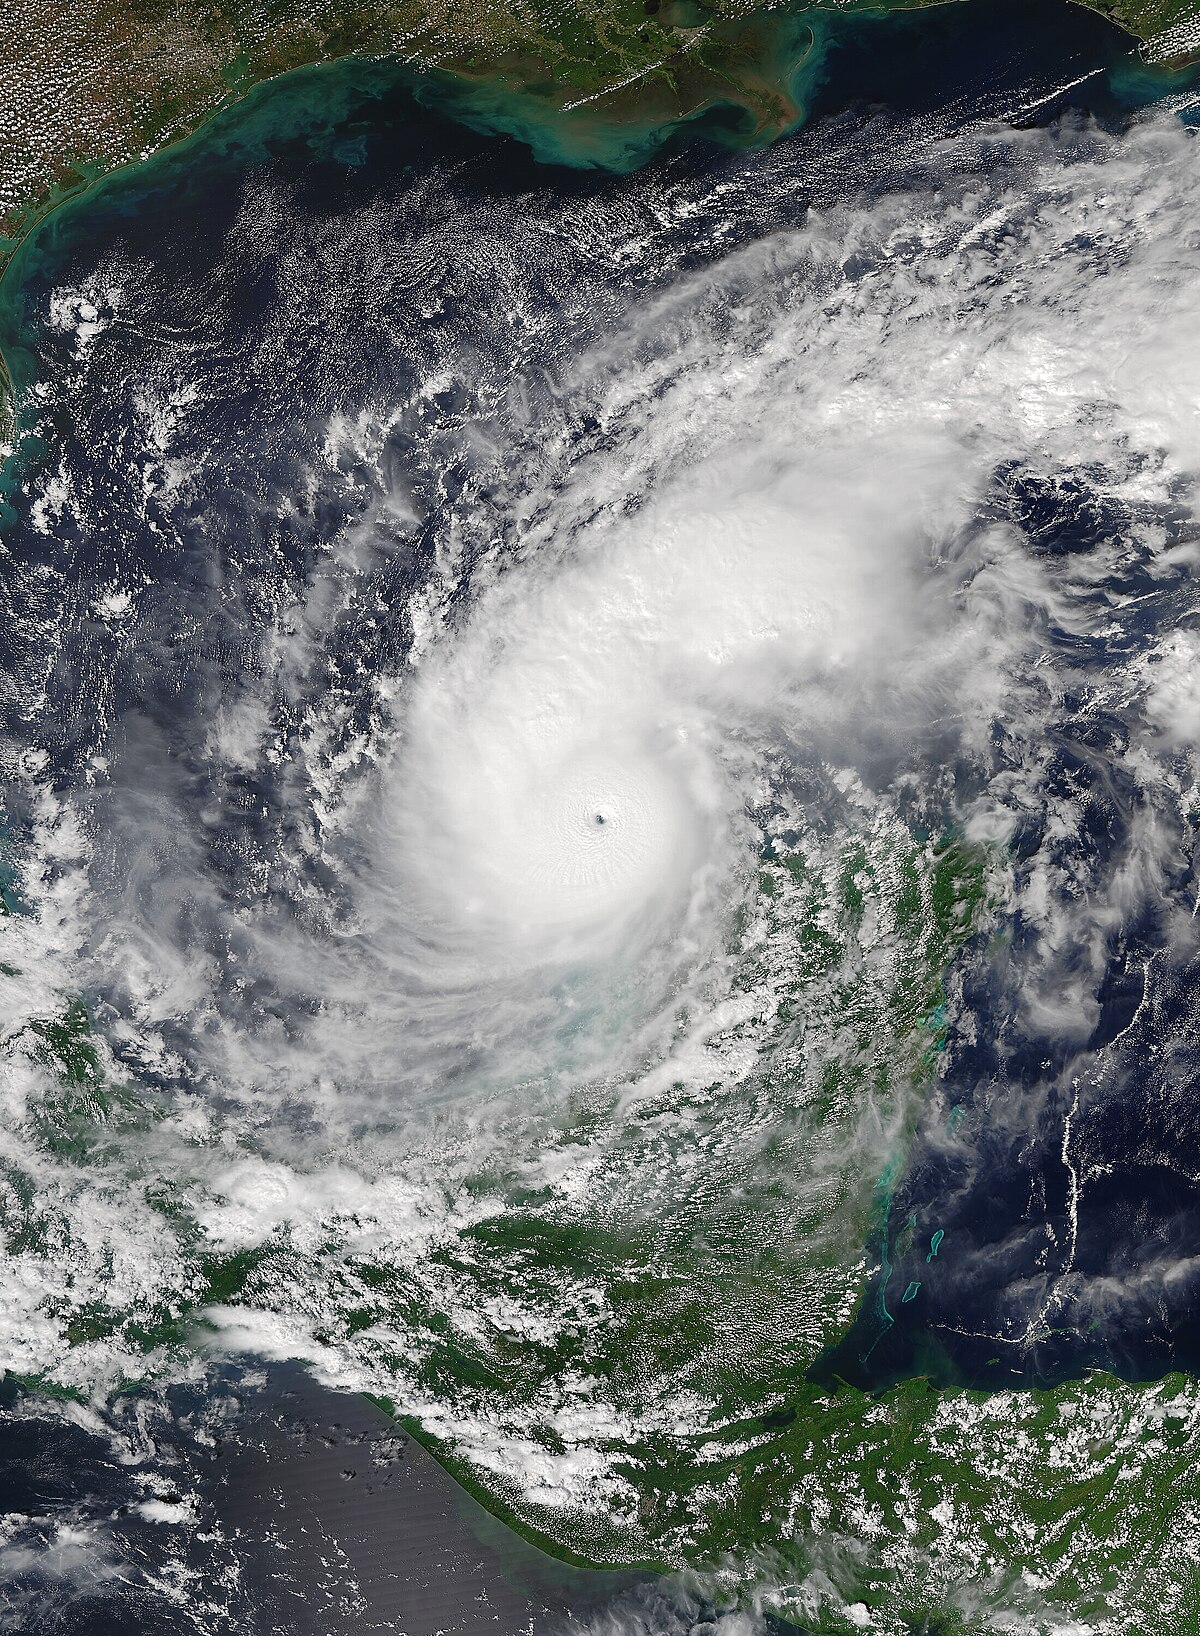

<h3> Data </h3>

<h3>Using python3 and ecCodes</h3>

In [1]:
from eccodes import *
import numpy as np
import sys
# for mapping projections
import cartopy.crs as ccrs 
#for mapping features ( land color country boundaries  etc)
import cartopy.feature as cfeature 
#for formatting the map lat lon axis
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter 
# python plotting library
import matplotlib.pyplot as plt 
# to allow plots to be show on the notebook
%matplotlib inline 

In [2]:
print(f" python version    : {sys.version_info}")
print(f" eccodes version   : {codes_get_api_version()}")

 python version    : sys.version_info(major=3, minor=12, micro=7, releaselevel='final', serial=0)
 eccodes version   : 2.38.0


In [4]:
BUFR_FILE="./data/miltonDet.bufr"

We will first see how many messages we have in the file

In [5]:
with open(BUFR_FILE,'rb') as f:
    nmsg=codes_count_in_file(f)
    print(f" number of messages : {nmsg}")
    

 number of messages : 1


<h3> TC BUFR structure  </h3>

There is a command line tool called **bufr_dump** that allows you to see the contents of the file.

In [6]:
with open(BUFR_FILE,'rb') as f:
    nmsg=codes_count_in_file(f)
    ## we need to get a 'handle' (bid) to a BUFR message to be able to read it
    bid=codes_bufr_new_from_file(f)
    ## once we have the handle, we can 'open' the message 
    codes_set(bid,'unpack',1)
    stormName=codes_get(bid,'longStormName')
    stormId=codes_get(bid,'stormIdentifier')
    ensembleMember=codes_get(bid,'ensembleMemberNumber')
    

In [7]:
print(f" storm name : {stormName}  storm Identifier : {stormId} member :{ensembleMember}")

 storm name :     MILTON  storm Identifier : 14L member :52


So we are going to look at the TC Milton that happened this year. The BUFR file contains the member number 52 of the ensemble.

if you look at the output of bufr_dump -p BUFR_FILE we see some keys appear with a 'rank' such as

#1#latitude=23.8
#1#longitude=-85.9
#2#meteorologicalAttributeSignificance=5
#2#latitude=23.7
#2#longitude=-85.8

so we have #1#latitude #2#latitude and so on. As we want to plot the trajectory of the TC we would need to read all the latitudes and longitudes 
On the other hand, we need to know, how many time steps we have in the file. For this we can use

bufr_dump -p BUFR_FILE |grep "timePeriod" 



As the latitude and longitude appear twice ( one for the "pressure block" and one for the "wind block") we need to be careful and select the latitudes and longitudes related to the pressure block. To see this we can use again bufr_dump and find the proper rank to use to pick the latitudes and longitudes related to the pressure

In [8]:
N_STEPS=15
lat_p=np.zeros(N_STEPS,dtype=float)
lon_p=np.zeros(N_STEPS,dtype=float)
pressure=np.zeros(N_STEPS,dtype=float)
for k in range(0,N_STEPS):
    i_rank=2*(k+1)+2 
    lat_key=f"#{i_rank}#latitude"
    lat_p[k]=codes_get(bid,lat_key)

    lon_key=f"#{i_rank}#longitude" 
    lon_p[k]=codes_get(bid,lon_key)
# the pressure for the first timestep has rank 2 so k+2, and increases by 1 every time step 
    pres_key=f"#{k+2}#pressureReducedToMeanSeaLevel"
    pressure[k]=codes_get(bid,pres_key)
    print(f" k : {k:3d} lat : {lat_p[k]:.2f}  lon: {lon_p[k]:5.2f} pressure : {pressure[k]:9.2f} Pa")

 k :   0 lat : 25.20  lon: -85.10 pressure :  96200.00 Pa
 k :   1 lat : 26.30  lon: -84.80 pressure :  95300.00 Pa
 k :   2 lat : 27.00  lon: -83.90 pressure :  95700.00 Pa
 k :   3 lat : 27.50  lon: -83.30 pressure :  96800.00 Pa
 k :   4 lat : 28.10  lon: -82.30 pressure :  97900.00 Pa
 k :   5 lat : 28.20  lon: -81.20 pressure :  98900.00 Pa
 k :   6 lat : 28.30  lon: -79.90 pressure :  99200.00 Pa
 k :   7 lat : 28.50  lon: -78.40 pressure :  99500.00 Pa
 k :   8 lat : 28.70  lon: -76.30 pressure :  99500.00 Pa
 k :   9 lat : 28.40  lon: -76.50 pressure :  99700.00 Pa
 k :  10 lat : 28.10  lon: -75.40 pressure :  99900.00 Pa
 k :  11 lat : 28.80  lon: -74.20 pressure : 100000.00 Pa
 k :  12 lat : 29.80  lon: -73.70 pressure : 100100.00 Pa
 k :  13 lat : 30.10  lon: -73.50 pressure :  99800.00 Pa
 k :  14 lat : 29.50  lon: -71.40 pressure : 100000.00 Pa


Now we have all the latitudes,longitudes and pressures we need to plot the trajectory

<h3> Plotting the TC data </h3>

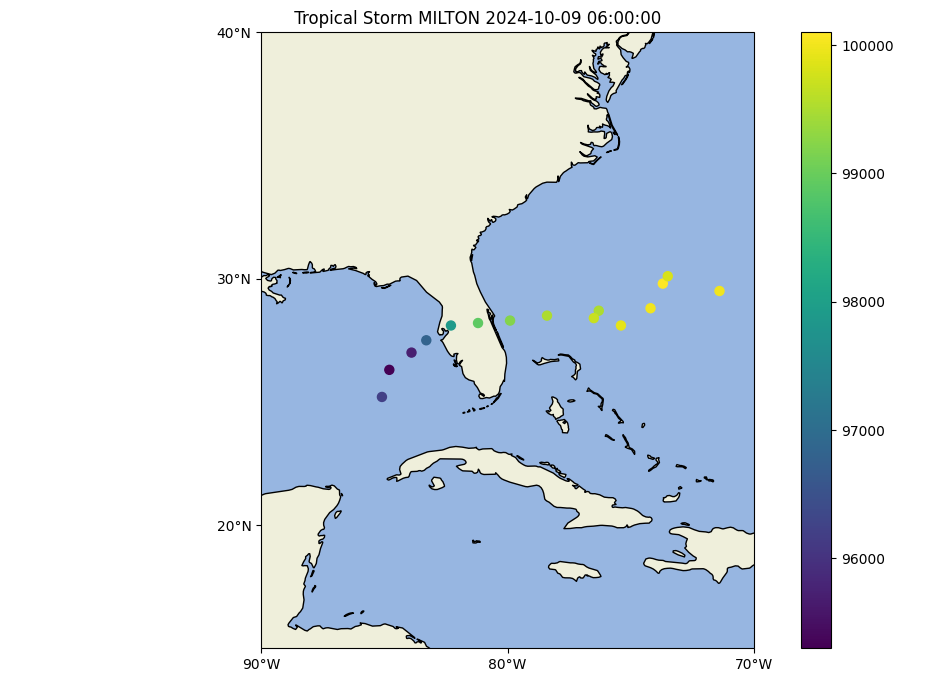

In [8]:
plt.rcParams['figure.figsize']=[12,8]
plt.title(' Tropical Storm MILTON 2024-10-09 06:00:00')
plt.axis('off')

ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90,-70,15,40])
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks([-90,-80,-70],crs=ccrs.PlateCarree())
ax.set_yticks([20,30,40],crs=ccrs.PlateCarree())
lon_formatter=LongitudeFormatter(zero_direction_label=True)
lat_formatter=LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
cbar=plt.scatter(lon_p,lat_p,c=pressure,s=42,transform=ccrs.PlateCarree())
plt.colorbar(cbar)
plt.show()

<h3> Plotting TC forecast and TC observation </h3>

 k :   0 lat : 25.20  lon: -85.10 pressure :  96200.00 Pa
 k :   1 lat : 26.30  lon: -84.80 pressure :  95300.00 Pa
 k :   2 lat : 27.00  lon: -83.90 pressure :  95700.00 Pa
 k :   3 lat : 27.50  lon: -83.30 pressure :  96800.00 Pa
 k :   4 lat : 28.10  lon: -82.30 pressure :  97900.00 Pa
 k :   5 lat : 28.20  lon: -81.20 pressure :  98900.00 Pa
 k :   6 lat : 28.30  lon: -79.90 pressure :  99200.00 Pa
 k :   7 lat : 28.50  lon: -78.40 pressure :  99500.00 Pa
 k :   8 lat : 28.70  lon: -76.30 pressure :  99500.00 Pa
 k :   9 lat : 28.40  lon: -76.50 pressure :  99700.00 Pa
 k :  10 lat : 28.10  lon: -75.40 pressure :  99900.00 Pa
 k :  11 lat : 28.80  lon: -74.20 pressure : 100000.00 Pa
 k :  12 lat : 29.80  lon: -73.70 pressure : 100100.00 Pa
 k :  13 lat : 30.10  lon: -73.50 pressure :  99800.00 Pa
 k :  14 lat : 29.50  lon: -71.40 pressure : 100000.00 Pa
observation lat: 23.8 lon: -85.9  pressure :  90700.00 Pa


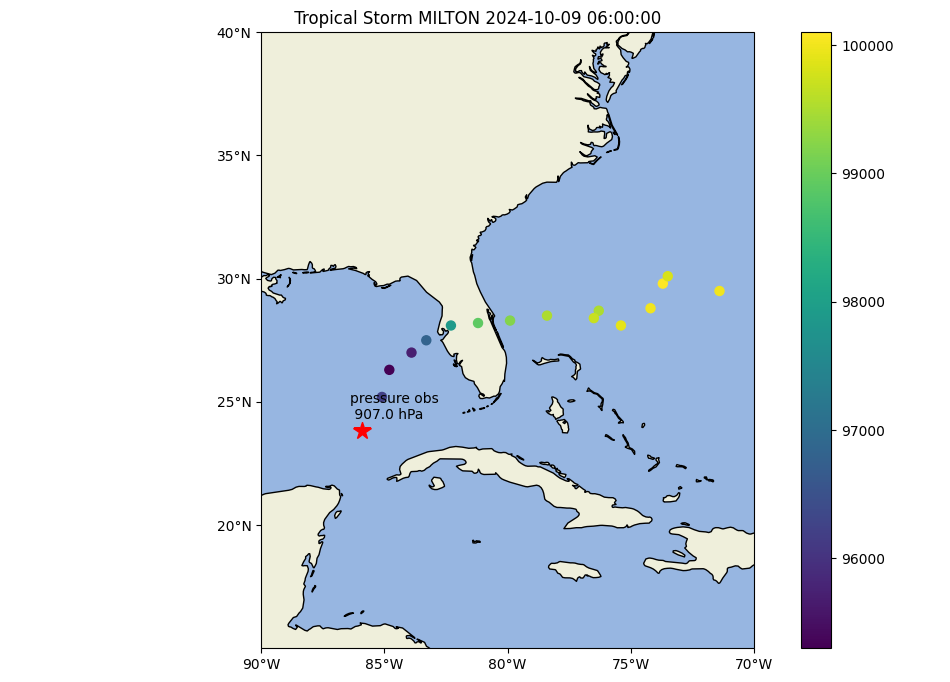

In [9]:
from eccodes import *
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter 
import pandas as pd 
%matplotlib inline

def read_ensemble_file(bufrFileEns):
    '''
    reads the bufr file and returns a dataframe
    '''
    N_STEPS=15
    lat_p=np.zeros(N_STEPS,dtype=float)
    lon_p=np.zeros(N_STEPS,dtype=float)
    pressure=np.zeros(N_STEPS,dtype=float)
    with open(bufrFileEns,'rb') as f:
        bid=codes_bufr_new_from_file(f)
        codes_set(bid,'unpack',1)
        for k in range(0,N_STEPS):
            i_rank=2*(k+1)+2 
            lat_key=f"#{i_rank}#latitude"
            lat_p[k]=codes_get(bid,lat_key)

            lon_key=f"#{i_rank}#longitude" 
            lon_p[k]=codes_get(bid,lon_key)
            # the pressure for the first timestep has rank 2 so k+2, and increases by 1 every time step 
            pres_key=f"#{k+2}#pressureReducedToMeanSeaLevel"
            pressure[k]=codes_get(bid,pres_key)
            print(f" k : {k:3d} lat : {lat_p[k]:.2f}  lon: {lon_p[k]:5.2f} pressure : {pressure[k]:9.2f} Pa")
        codes_release(bid) #important to release the handle after reading each message otherwise if will fill up the memory
    df=pd.DataFrame()
    df['lat']=lat_p
    df['lon']=lon_p
    df['pressure']=pressure
    return df  

def read_obs_file(bufrObsFile):
    with open(bufrObsFile,'rb') as f:
        bid=codes_bufr_new_from_file(f)
        codes_set(bid,'unpack',1)
        lat=codes_get(bid,'latitude')
        lon=codes_get(bid,'longitude')
        pressure=codes_get(bid,'#1#nonCoordinatePressure')
        codes_release(bid) # important to release the bid to avoid filling up memory
    return lon,lat,pressure

def plot_ens_and_obs(df_ens,lon_obs,lat_obs,pres_obs):
    plt.rcParams['figure.figsize']=[12,8]
    plt.title(' Tropical Storm MILTON 2024-10-09 06:00:00')
    plt.axis('off')
    lon_p=df_ens['lon'].values
    lat_p=df_ens['lat'].values
    pressure=df_ens['pressure'].values
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-90,-70,15,40])
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.set_xticks([-90,-85,-80,-75,-70],crs=ccrs.PlateCarree())
    ax.set_yticks([20,25,30,35,40],crs=ccrs.PlateCarree())
    lon_formatter=LongitudeFormatter(zero_direction_label=True)
    lat_formatter=LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cbar=plt.scatter(lon_p,lat_p,c=pressure,s=42,transform=ccrs.PlateCarree())
    plt.plot(lon_obs,lat_obs,color='red',transform=ccrs.PlateCarree(),marker='*',markersize=13)
    # used 0.5 to place the legend around the star
    plt.text(lon_obs-0.5,lat_obs+0.5,f"pressure obs \n {pres_obs/100} hPa")
    plt.colorbar(cbar)
    plt.show()


def main():
    BUFR_FILE_ENS="./data/miltonDet.bufr"
    BUFR_FILE_OBS="./data/miltonobs.bufr"
    df_ens=read_ensemble_file(BUFR_FILE_ENS)
    lon_obs,lat_obs,pres_obs=read_obs_file(BUFR_FILE_OBS)
    print(f"observation lat: {lat_obs} lon: {lon_obs}  pressure : {pres_obs:9.2f} Pa")
    plot_ens_and_obs(df_ens,lon_obs,lat_obs,pres_obs)

if __name__=="__main__":
    main()

    
    

<h3> General structure of a reader</h3>

In [10]:
#### import eccodes and other libraries that may be needed 
### cartopy matplotlib for plotting.. 
from eccodes import *
import numpy as np
def main():
    f=open(filename,'rb') # open the file for binary reading
    ### count how many messages are in the file
    nmsg=codes_count_in_file(f)
    for i in range(0,nmsg): ### loop over the messages
        ### create the handle to the bufr message
        bid=codes_bufr_new_from_file(f)
        
        codes_set(bid,"unpack",1) # to open the data section
        
        ### for keys that have only one value use codes_get
        lat=codes_get(bid,"latitude") 
        
        ### for keys that have many values (arrays) use codes_get_array
        pressure=codes_get_array(bid,"#2#pressure")
        
        codes_release(bid) # IMPORTANT TO RELEASE THE bufr handle
        #### otherwise memory will be exhausted  and the program will crash

    f.close() # close the file

<h3> Useful links </h3>